In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

/home/miglesia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def initialize_data():
    #Import data file
    df = pd.read_stata("exam1.dta")
    df.to_csv("exam1.dta".replace(".dta", ".csv"))    

    #Add log variables
    df['log_rK'] = np.log10(df['rK'])
    df['log_routput'] = np.log10(df['routput'])
    df['log_emp'] = np.log10(df['emp'])

    #Add intercept
    df['intercept'] = 1
    
    return df

#Add dummies function
def add_dummy(dataframe, column):
    s = pd.Series(list(column))
    dum = pd.get_dummies(s)
    return pd.concat([dataframe,dum], axis = 1)

def OLS(X, y):
    """
    Run OLS and show summary
    """ 
    model = sm.OLS(y, X)
    results = model.fit()
    return results

def make_plot(beta, x, y, z, elev=30., azim=120, xlab = 'log_rK', ylab = 'log_emp', zlab = 'log_routput'):
    #create grid
    X,Y = np.meshgrid(np.arange(min(x), max(x), 0.1), np.arange(min(y), max(y), 0.1))
    XX = X.flatten()
    YY = Y.flatten()

    # evaluate it on grid
    Z = beta[xlab]*X + beta[ylab]*Y + beta['intercept']

    # plot points and fitted surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
    ax.scatter(x, y, z, c='r', s=50)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    ax.set_zlabel(zlab)
    ax.axis('equal')
    ax.axis('tight')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2770.
Date:                Mon, 27 Mar 2017   Prob (F-statistic):               0.00
Time:                        15:09:55   Log-Likelihood:                 6265.9
No. Observations:                6500   AIC:                        -1.253e+04
Df Residuals:                    6497   BIC:                        -1.251e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept   1.042e-08      0.001    9.1e-06      1.0

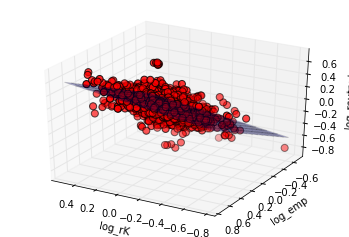

In [3]:
"""
WITHIN GROUP / FIXED EFFECTS ESTIMATOR
"""

#Useful to have group means
means = initialize_data().groupby(['id']).transform('mean')
    
#Transform for Within / FE
df_fe = initialize_data()
df_fe[['log_routput','log_rK','log_emp']]=df_fe[['log_routput','log_rK','log_emp']]-means[['log_routput','log_rK','log_emp']]

results_fe = OLS(df_fe[['intercept','log_rK','log_emp']], df_fe['log_routput'])

print results_fe.summary()

make_plot(results_fe.params, df_fe['log_rK'], df_fe['log_emp'], df_fe['log_routput'])

In [4]:
"""
POOLED
"""

#Add dummies for year and id
df = initialize_data()
df_dum = add_dummy(df,df['year'])
df_dum = add_dummy(df,df['id'])

results_ols = OLS(df_dum[df_dum.columns.difference(['id','year','rK','routput','emp','sector','indu','log_routput'])], df['log_routput'])


                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     9357.
Date:                Mon, 27 Mar 2017   Prob (F-statistic):               0.00
Time:                        15:10:22   Log-Likelihood:                 3650.2
No. Observations:                6500   AIC:                            -7294.
Df Residuals:                    6497   BIC:                            -7274.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept      1.2305      0.022     55.213      0.0

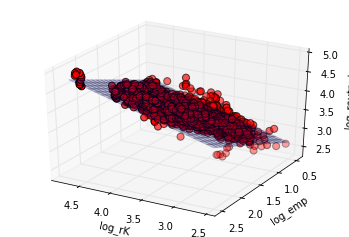

In [6]:
"""
RANDOM EFFECTS ESTIMATOR
"""

#Random effects

#First use results of OLS to get theta (th)
sigma2_e = np.var(df_fe['log_routput']-results_ols.fittedvalues)
sigma2_a = np.var(results_ols.params[range(0,500)])
T = len(list(set(df['year'])))
th = 1 - np.sqrt(sigma2_e/(sigma2_e + T * sigma2_a))

#Transform for Random
df_re = initialize_data()
df_re[['log_routput','log_rK','log_emp']]=df[['log_routput','log_rK','log_emp']]- th*means[['log_routput','log_rK','log_emp']]

results_re = OLS(df_re[['intercept','log_rK','log_emp']], df_re['log_routput'])

print results_re.summary()

make_plot(results_re.params, df_re['log_rK'], df_re['log_emp'], df_re['log_routput'])


                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1181.
Date:                Mon, 27 Mar 2017   Prob (F-statistic):          1.46e-189
Time:                        15:10:30   Log-Likelihood:                 100.23
No. Observations:                 500   AIC:                            -194.5
Df Residuals:                     497   BIC:                            -181.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept      2.2058      0.125     17.613      0.0

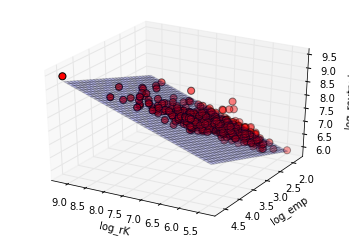

In [7]:
"""
BETWEEN EFFECTS ESTIMATOR
"""

#Transform for Between
df_be = initialize_data().groupby(['id'], axis=0).mean()

results_be = OLS(df_be[['intercept','log_rK','log_emp']], df_be['log_routput'])
print results_be.summary()
make_plot(results_be.params, df_be['log_rK'], df_be['log_emp'], df_be['log_routput'])


In [8]:
"""
HAUSMAN TEST
"""

# Pull data out
params_diff = results_fe.params - results_re.params

v_b = results_fe.cov_params()
v_B = results_re.cov_params()

# compute test statistic
chi2 = np.dot(params_diff.T, np.linalg.pinv(v_b - v_B).dot(params_diff))
print chi2

5375.98


In [9]:
"""
HAUSMAN TEST 2 (normalized covariances)
"""

endog, exog = results_fe.model.endog_names, results_fe.model.exog_names

# Sum of squared (whitened) residuals / 1 endogenous vars (log_routput)
se2 = results_re.ssr / len(endog)


cov_diff = results_fe.normalized_cov_params - results_re.normalized_cov_params
cov_diffpinv = np.linalg.pinv(cov_diff)

H = np.dot(params_diff, np.dot(cov_diffpinv, params_diff))/se2
print H

-3.41518690712
